# Search for unique marker genes (Fig 7)

In [1]:
from __future__ import division
import sys
import random
import copy
import math
import json

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

sys.path.append("../resources/")
import sct
reload(sct)

sns.set_style("ticks")
sns.set_context("talk")

output_dir = "out/"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format)
    return None

mpl.rc('savefig', dpi=300)

pd.options.mode.chained_assignment = None  # default='warn'

# Load data

In [2]:
# Gene expression
df = pd.read_csv("../data/df_GH146_Fig2.csv.gz", header=0, index_col=0)

# Cluster labels
df_labels = pd.read_csv("../data/labels_HDBSCAN.csv", sep="\t", header=0, index_col=0)

In [3]:
# Load names of TFs and CSM genes
def load_list(infile):
    X = []
    with open(infile) as f:
        for line in f:
            X.append(line.rstrip())
    return X

def write_list(X, outfile):
    with open(outfile, 'w') as out:
        for x in X:
            out.write(str(x) + "\n")

CSMs = load_list("../resources/CSMs.txt")
TFs = load_list("../resources/TFs.txt")
genes_genome_noTFs_noCSMs = list(set(list(df.index)) - set(TFs) - set(CSMs))

# Calculate DE for each cluster versus all other cells on cluster

In [8]:
# Make dictionary of names belonging to each label

names_label = {}
names_notLabel = {}

for label in df_labels["label"].value_counts().index:
    names1 = list(df_labels[df_labels["label"] == label].index)
    names2 = list(df_labels[df_labels["label"] != label].index)
    names_label[label] = names1
    names_notLabel[label] = names2

In [5]:
# Load results from calculation done on cluster
dfs_DE_UniqueMarkers = {}
for label in df_labels["label"].value_counts().index:
    if label == -1: continue
    infile = "GH146_UniqueMarkers/df_DE_GH146_UniqueMarkers_label_" + str(label) + ".csv"
    my_df = pd.read_csv(infile, index_col=0, header=0)
    dfs_DE_UniqueMarkers[label] = my_df

In [6]:
# Take a peek at results
dfs_DE_UniqueMarkers[0].head(20)

,medianA,medianB,pvalue,pvalue_adj
symbol,,,,
dpr20,10.054347,0.000000,1.272326e-38,1.974905e-34
CG18367,0.000000,0.000000,8.716792e-25,1.353020e-20
CG11768,4.592354,0.000000,3.792230e-20,5.886299e-16
CG1504,7.651145,0.000000,1.428311e-19,2.217024e-15
CG30271,0.000000,0.000000,2.223506e-15,3.451326e-11
run,7.972043,0.000000,2.542996e-15,3.947238e-11
CG17193,2.687191,0.000000,2.066289e-14,3.207294e-10
tnc,0.000000,8.724331,1.085926e-12,1.685574e-08
CG43729,10.686737,7.842357,2.982646e-12,4.629663e-08


# Calculate additional metrics to identify unique markers

In [9]:
# For each putative unique marker, calculate the number of cells positive and negative
for label, my_df in dfs_DE_UniqueMarkers.items():
    names1 = names_label[label]
    names2 = names_notLabel[label]
    frac_expr1 = np.sum(df[names1].loc[my_df.index] > 3, axis=1) / float(len(names1))
    frac_expr2 = np.sum(df[names2].loc[my_df.index] > 3, axis=1) / float(len(names2))
    my_df["frac_expr1"] = frac_expr1
    my_df["frac_expr2"] = frac_expr2

In [10]:
# Take a peek
dfs_DE_UniqueMarkers[8].head()

,medianA,medianB,pvalue,pvalue_adj,frac_expr1,frac_expr2
symbol,,,,,,
fru,9.290849,0.0,7.238719e-135,1.123594e-130,0.944444,0.035264
CG31676,10.010857,0.0,7.645734e-86,1.186771e-81,0.981481,0.146096
CG15537,5.924855,0.0,3.857022e-83,5.986870e-79,0.601852,0.023929
dpr15,8.249282,0.0,2.450317e-60,3.803381e-56,0.731481,0.119647
br,8.245939,0.0,1.227377e-54,1.905134e-50,0.935185,0.204030


# Call unique markers

In [11]:
# Take significant genes from each cluster
pvalue_adj_cutoff = 0.05
sig_genes = []
sig_genes_labels = []
for label, my_df in dfs_DE_UniqueMarkers.items():
    my_sig_genes = my_df[(my_df["pvalue_adj"] < pvalue_adj_cutoff) & 
                         (my_df["medianA"] > 3)]
    sig_genes.extend(list(my_sig_genes.index))
    sig_genes_labels.extend([label]*len(my_sig_genes))

print "Significant genes", len(sig_genes)

Significant genes 1103


In [12]:
# Filter for genes that are only found for one cluster
putative_markers = []
from collections import Counter
counts = Counter(sig_genes)
for gene, count in counts.items():
    if count == 1:
        putative_markers.append(gene)
        
print "Found only for one cluster", len(putative_markers)

# Find labels associated with these genes
putative_markers_labels = [sig_genes_labels[sig_genes.index(gene)] for gene in putative_markers]

Found only for one cluster 257


In [20]:
# Calculate summary of expression of each gene within each cluster
def calc_summary_by_label(df, labels, summary_func=np.mean):
    df_temp = copy.deepcopy(df.T)
    df_temp["label"] = labels
    df_summary_by_label = df_temp.groupby("label").aggregate(summary_func).T
    del df_temp
    return df_summary_by_label

# Calculate fraction of cells expressing gene within each cluster
# Strangely, it appears that execution never terminates. You need to STOP execution, but it works.
def frac_expressing(x):
    return np.mean(x > 3)
df_frac_expr_labels = calc_summary_by_label(df, df_labels["label"], summary_func=frac_expressing)
df_frac_expr_labels.head()
del df_frac_expr_labels[-1] # drop cells with no cluster assignment

In [21]:
# Here we discover unique markers

# Filter for genes that are robustly expressed within cluster and not expressed outside
# We can choose uniqueness and robustness of expression within cluster

markers = []
for gene, label in zip(putative_markers, putative_markers_labels):
    my_df = dfs_DE_UniqueMarkers[label].loc[gene]
    if my_df["frac_expr1"] > 0.5:
        other_labels = list(set(df_frac_expr_labels.columns) - set([label]))
        if np.sum(df_frac_expr_labels[other_labels].loc[gene] > 0.1) == 0:
            markers.append(gene)
            print gene, label, my_df["frac_expr1"], my_df["frac_expr2"]

PPO2 23 0.6 0.00891861761427
trol 2 0.651162790698 0.0093131548312
DIP-zeta 4 1.0 0.013437849944
RunxB 24 0.571428571429 0.00335195530726
Tk 19 0.769230769231 0.0044994375703
CG8012 24 0.571428571429 0.00223463687151


# Plot expression of markers

In [22]:
# Define function to plot violinplots of expression by labels
def plot_violins(df, genes, df_labels, swarm=False, **kwargs):
    
    fig, axes = plt.subplots(len(genes), 1, figsize=(10,2*len(genes)), sharex=True)

    df_temp = df.copy()
    df_temp.loc["label"] = df_labels["label"]
    df_temp = df_temp.T[df_temp.T.label != -1].T # drop cells with no cluster assignment
    
    for ax, gene in zip(axes, genes):
        my_df = df_temp.loc[["label", gene]].T
        sns.violinplot(x="label", y=gene, data=my_df, ax=ax,
                       cut=0, scale="width", palette="nipy_spectral",
                       **kwargs)
        if swarm:
            sns.swarmplot(x="label", y=gene, data=my_df, ax=ax)
        ax.set_ylim(bottom=0, top=14)
        ax.set_xlabel("")
    
    ax.set_xlabel("Cluster")
    # xticklabels = [item.get_text() for item in ax.get_xticklabels()]
    xticklabels = range(0,max(df_labels["label"])+1)
    ax.set_xticklabels([str(int(x)) for x in xticklabels])
    plt.tight_layout()
    return fig, axes

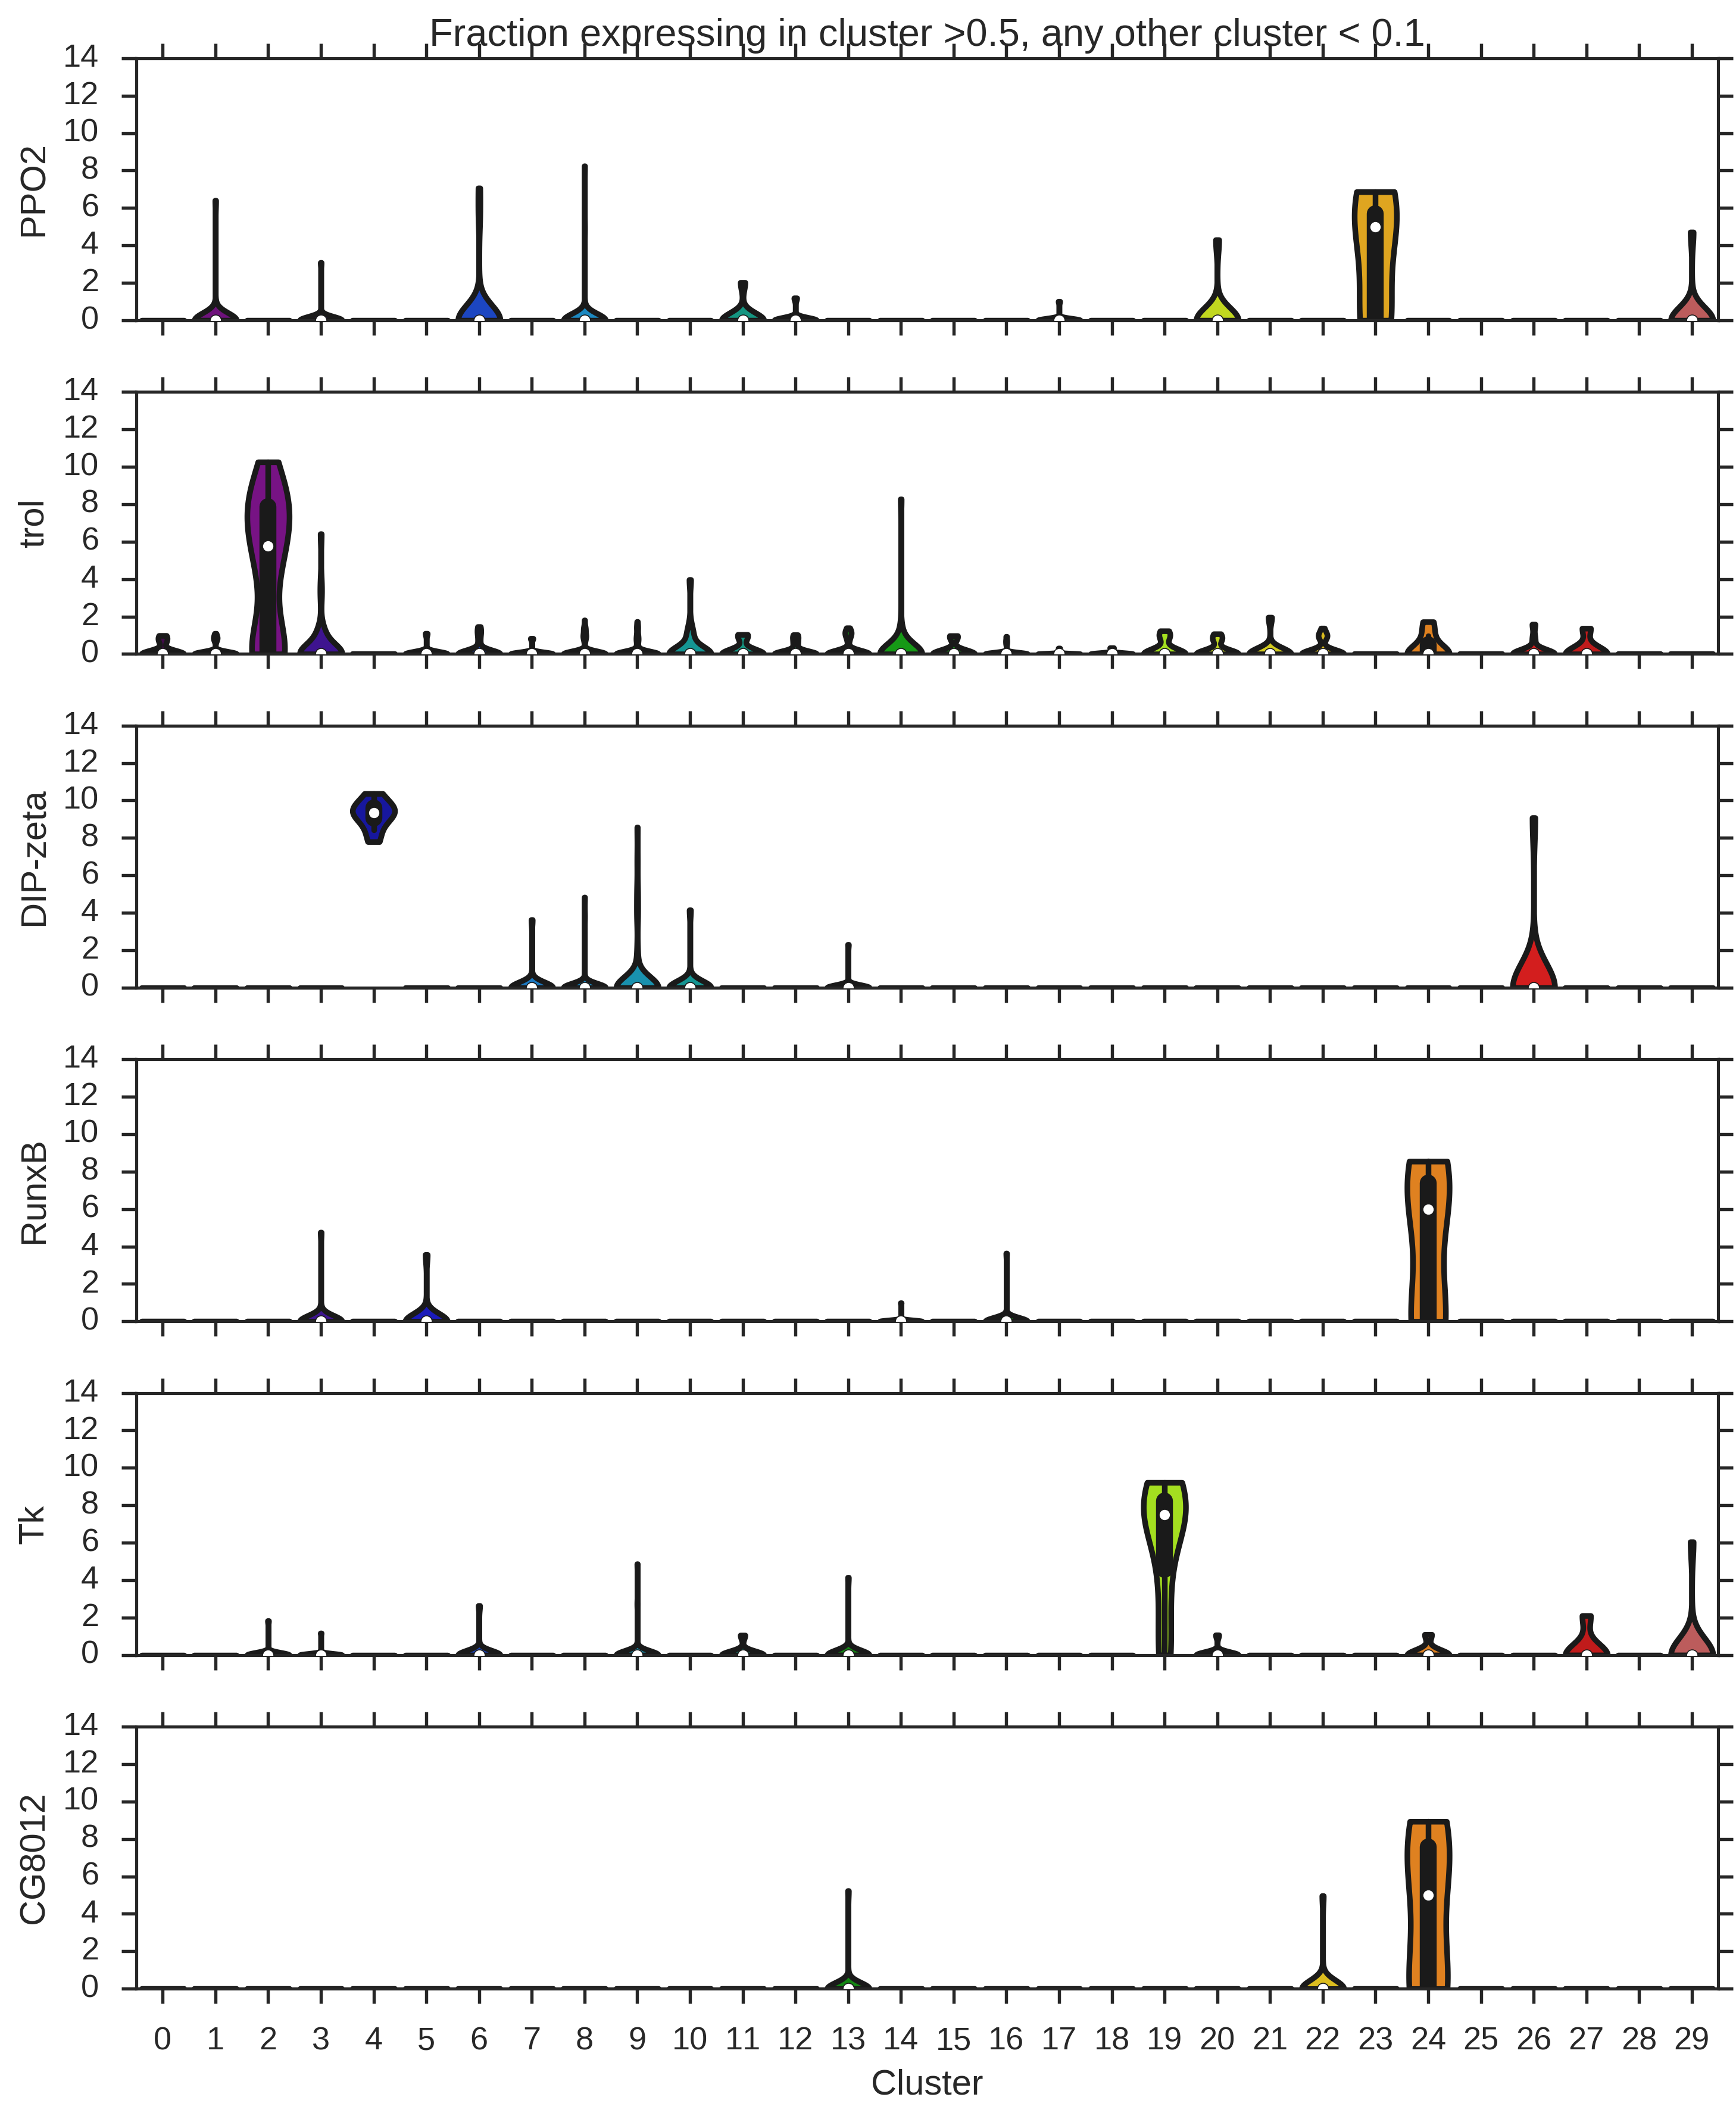

In [23]:
fig, axes = plot_violins(df, markers, df_labels, swarm=False)
axes[0].set_title("Fraction expressing in cluster >0.5, any other cluster < 0.1")

# Search for unique markers using less stringent parameters

In [24]:
markers = []
for gene, label in zip(putative_markers, putative_markers_labels):
    my_df = dfs_DE_UniqueMarkers[label].loc[gene]
    if my_df["frac_expr1"] > 0.5:
        other_labels = list(set(df_frac_expr_labels.columns) - set([label]))
        if np.sum(df_frac_expr_labels[other_labels].loc[gene] > 0.25) == 0:
            markers.append(gene)
            print gene, label, my_df["frac_expr1"], my_df["frac_expr2"]

Scp2 5 0.809523809524 0.0261066969353
CG10433 18 0.833333333333 0.0112359550562
Dok 23 0.6 0.0490523968785
CG12171 29 0.533333333333 0.0856820744081
CG32262 25 0.555555555556 0.0839865621501
PPO2 23 0.6 0.00891861761427
CG33228 4 0.555555555556 0.073908174692
trol 2 0.651162790698 0.0093131548312
CG8216 26 0.9375 0.0293453724605
AstA 17 0.892857142857 0.0400457665904
CG16798 25 0.555555555556 0.0156774916013
DIP-zeta 4 1.0 0.013437849944
RunxB 24 0.571428571429 0.00335195530726
Cpr73D 24 0.571428571429 0.0134078212291
Arc2 4 0.666666666667 0.0951847704367
Tk 19 0.769230769231 0.0044994375703
Lac 25 0.555555555556 0.0212765957447
CG8012 24 0.571428571429 0.00223463687151
zfh2 24 1.0 0.0391061452514
CG13739 23 0.8 0.0234113712375


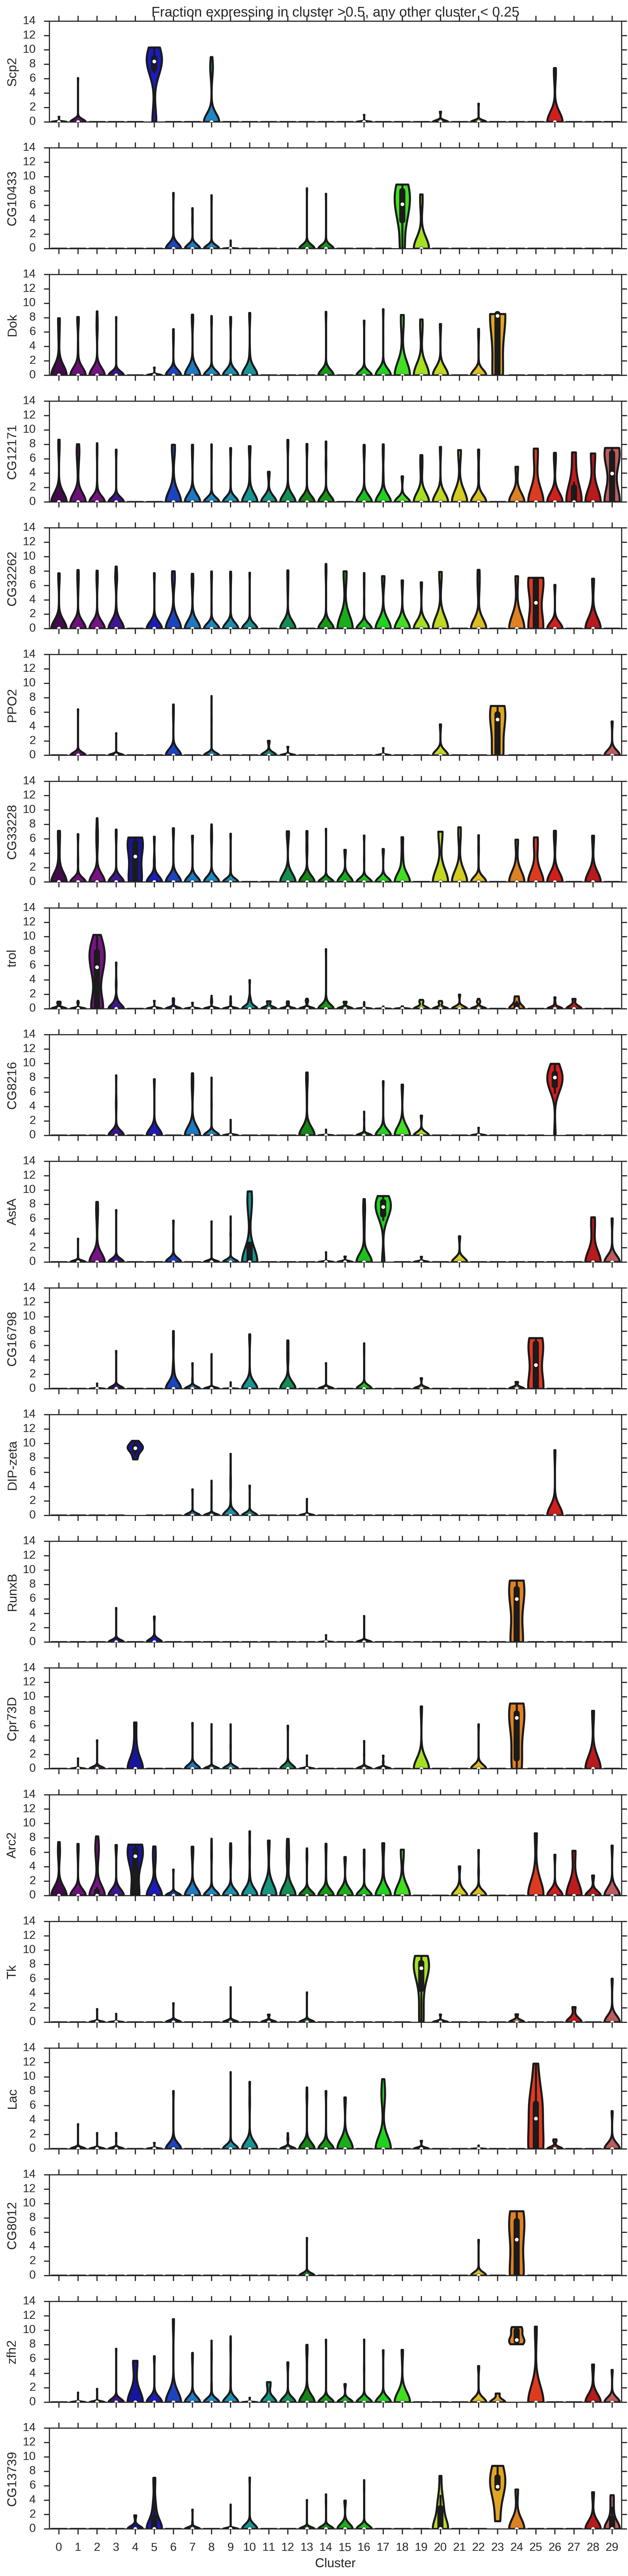

In [25]:
fig, axes = plot_violins(df, markers, df_labels, swarm=False)
axes[0].set_title("Fraction expressing in cluster >0.5, any other cluster < 0.25")

# Plot dropout rate as a function of expression level

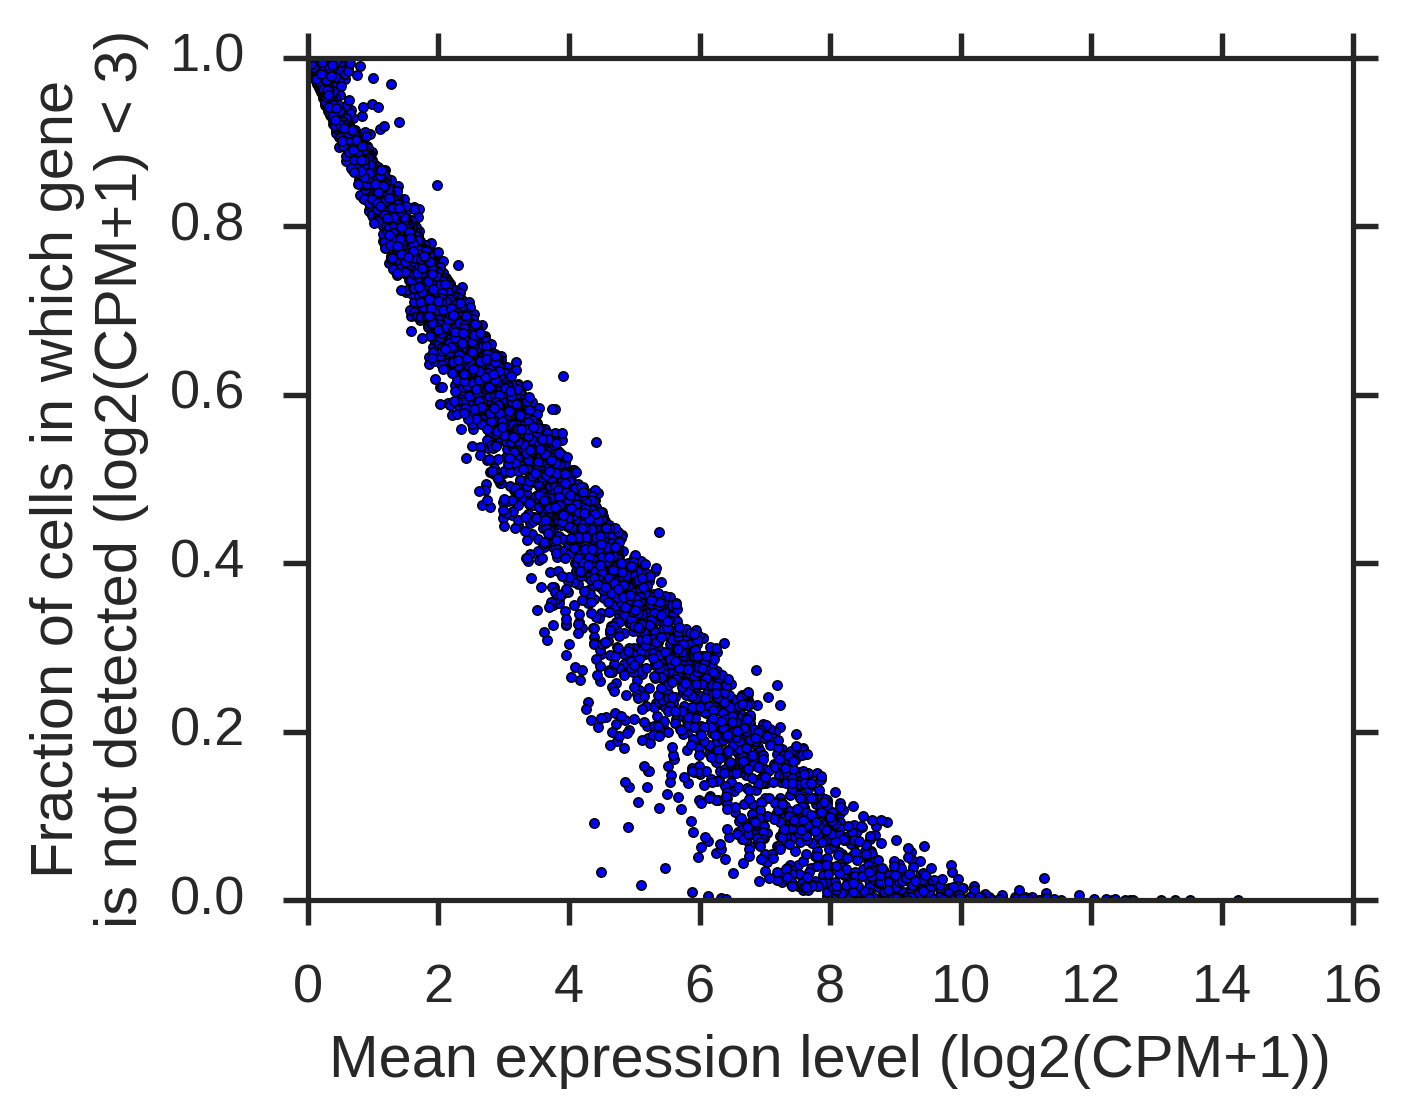

In [30]:
dropout_rate = np.sum(df < 3, axis=1) / df.shape[1]

x = np.mean(df, axis=1)
y = dropout_rate

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.scatter(x, y, marker=".")
ax.set_xlim(left=0)
ax.set_ylim(0,1)
ax.set_xlabel("Mean expression level (log2(CPM+1))")
ax.set_ylabel("Fraction of cells in which gene\nis not detected (log2(CPM+1) < 3)")
plt.tight_layout()

In [31]:
print "Mean dropout rate near 3:", np.mean(y[(x > 3.5) & (x < 4.5)])

Mean dropout rate near 3: 0.45850146672


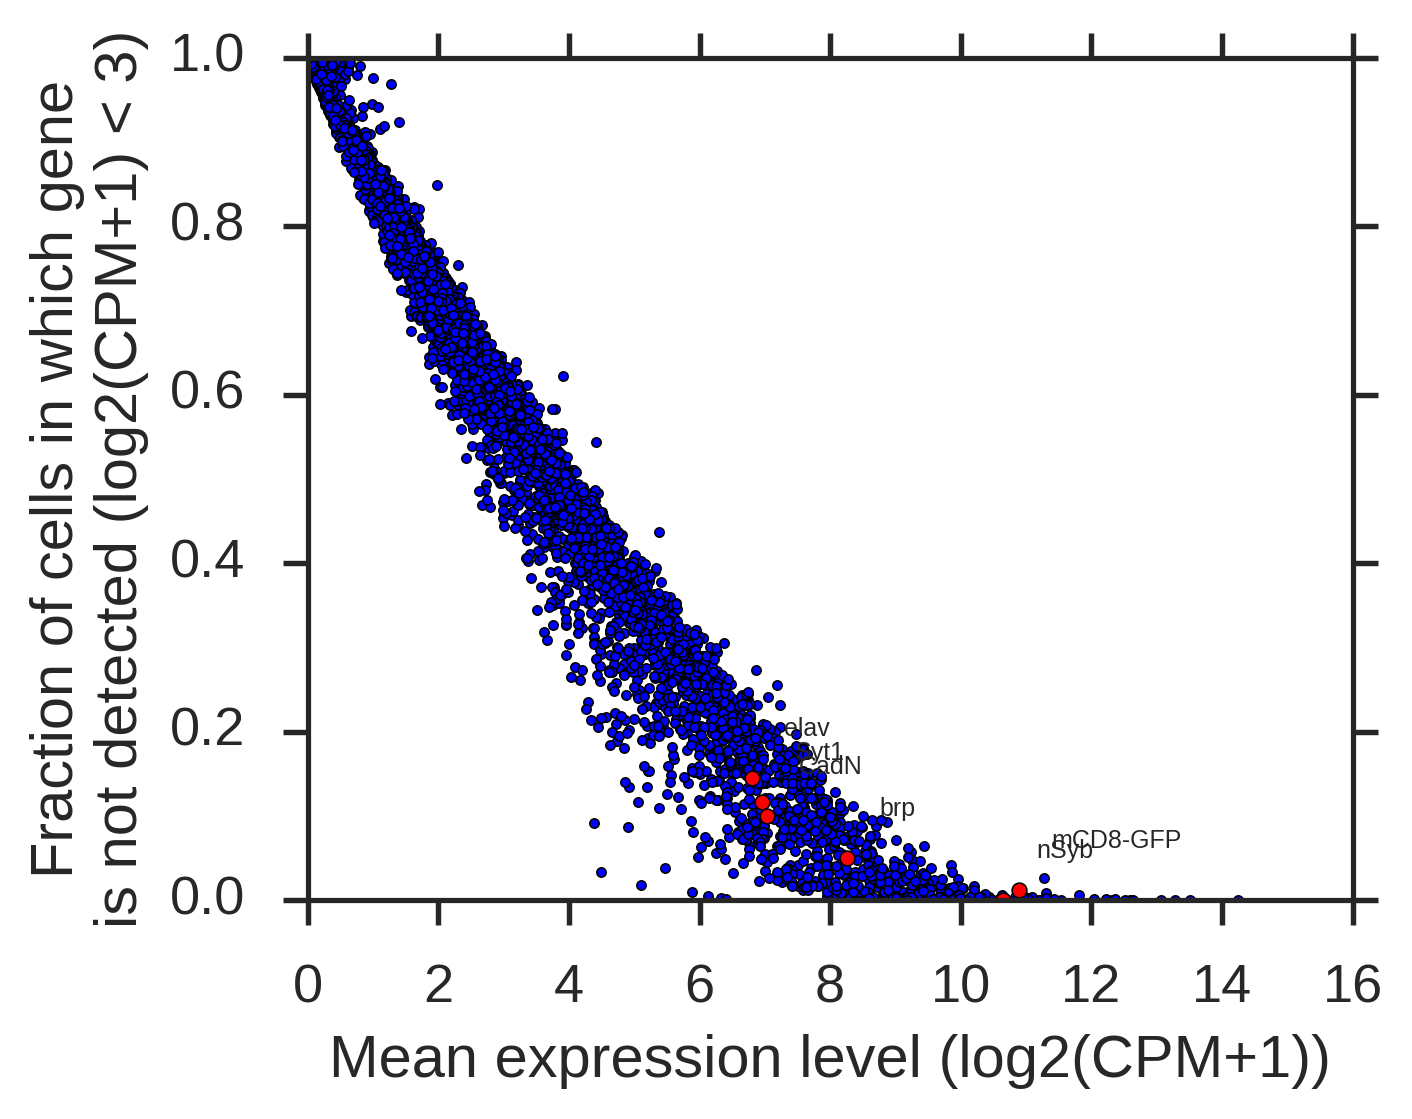

In [32]:
# What is the dropout rate of the marker genes used to filter cells?

genes_neuron_marker = ["mCD8-GFP", "elav", "brp", "Syt1", "nSyb", "CadN"]

dropout_rate = np.sum(df < 3, axis=1) / df.shape[1]

fig, ax = plt.subplots(1, 1, figsize=(5,4))

x = np.mean(df, axis=1)
y = dropout_rate
ax.scatter(x, y, marker=".")

x = np.mean(df, axis=1).loc[genes_neuron_marker]
y = dropout_rate.loc[genes_neuron_marker]
ax.scatter(x, y, marker=".", c="r", s=50)

ax.set_xlim(left=0)
ax.set_ylim(0,1)
ax.set_xlabel("Mean expression level (log2(CPM+1))")
ax.set_ylabel("Fraction of cells in which gene\nis not detected (log2(CPM+1) < 3)")

for myX, myY, label in zip(x, y, x.index):
    ax.text(myX+0.5, myY+0.05, label, fontsize=6)
    
plt.tight_layout()

# Calculation of probability of failure to detect marker genes due to dropouts

In [33]:
# Calculation of probability of detecting marker gene in 90% of cells
# for a single cluster, single gene

dropout_rate = np.sum(df < 3, axis=1) / df.shape[1]

x = np.mean(df, axis=1)
y = dropout_rate

# N_cluster = np.mean(df_labels["label"].value_counts())
N_cluster = min(df_labels["label"].value_counts())
P_dropout = np.mean(y[(x > 2.5) & (x < 3.5)])
N_dropouts_needed_for_failure_to_detect = N_cluster * 0.5
P_failure = P_dropout**N_dropouts_needed_for_failure_to_detect

print "Mean cluster size:", N_cluster
print "Smallest cluster:", min(df_labels["label"].value_counts())
print "Probability of dropout of given marker gene at 4 CPM:", P_dropout
print "Number of dropouts needed for failure to detect marker gene in >50% cells:", N_dropouts_needed_for_failure_to_detect
print "Probability of failure to detect marker gene in >50% cells:", P_failure

Mean cluster size: 5
Smallest cluster: 5
Probability of dropout of given marker gene at 4 CPM: 0.590134928777
Number of dropouts needed for failure to detect marker gene in >50% cells: 2.5
Probability of failure to detect marker gene in >50% cells: 0.267533579826


In [34]:
# Calculation for every cluster separately
N_cluster = df_labels["label"].value_counts()
N_dropouts_needed_for_failure_to_detect = N_cluster * 0.5 
P_failure = P_dropout ** N_dropouts_needed_for_failure_to_detect
print P_failure

 8     4.279286e-13
 9     2.234788e-11
 16    1.032798e-07
 1     8.515497e-07
 14    1.442975e-06
 13    1.442975e-06
 3     1.878378e-06
 2     1.189744e-05
 7     9.809528e-05
 10    2.163820e-04
 12    2.163820e-04
 6     3.666653e-04
 22    3.666653e-04
 17    6.213245e-04
 0     3.023184e-03
 5     3.935400e-03
 26    1.470993e-02
 29    1.914851e-02
 20    2.492638e-02
 19    3.244767e-02
 21    3.244767e-02
 15    4.223845e-02
 18    4.223845e-02
-1     4.223845e-02
 11    7.157422e-02
 4     9.317104e-02
 25    9.317104e-02
 28    9.317104e-02
 24    1.578809e-01
 27    2.055199e-01
 23    2.675336e-01
Name: label, dtype: float64


In [35]:
# Probability of failing to detect marker genes in N clusters
X = []
for i in range(10000):
    x = np.product(np.random.choice(P_failure, size=25, replace=False))
    X.append(x)
print np.mean(X)

4.39785136051e-62


In [36]:
# Probability of failing to detect marker genes in N clusters
X = []
for i in range(10000):
    x = np.product(np.random.choice(P_failure, size=15, replace=False))
    X.append(x)
print np.mean(X)

3.56687901096e-31


In [37]:
print "Number of cells per cluster"
df_labels["label"].value_counts()

Number of cells per cluster


 8     108
 9      93
 16     61
 1      53
 14     51
 13     51
 3      50
 2      43
 7      35
 10     32
 12     32
 6      30
 22     30
 17     28
 0      22
 5      21
 26     16
 29     15
 20     14
 19     13
 21     13
 15     12
 18     12
-1      12
 11     10
 4       9
 25      9
 28      9
 24      7
 27      6
 23      5
Name: label, dtype: int64